# Movie recommender system using signal diffusion

#### Contributors
* Jonathan Labhard
* Deniz Ira
* Daniil Dmitriev
* Paul Griesser

#### Team number
29

#### Dataset
Movielens 100k


In [204]:
'''General imports'''
import numpy as np
import pandas as pd
from scipy.spatial.distance import pdist, squareform, euclidean, seuclidean, sqeuclidean
import matplotlib.pyplot as plt
import networkx as nx
import collections
from pygsp import graphs, plotting, filters, utils
from surprise import SVD, SVDpp, CoClustering, KNNBaseline
from surprise import Dataset, Reader

## 0. Data acquisition
The data is obtained from the [movielens database](https://grouplens.org/datasets/movielens). We mainly use three of the datasets:
```
data
|-- user_id : ID of the user
|-- item_id : ID of the movie
|-- ratings: rating given by the user to the movie
|-- ts: timestamp

users
|-- user_id : ID of the user
|-- age
|-- sex
|-- occupation
|-- ts : timestamp

movies
|-- item_id : ID of the movie
|-- movie_title
|-- release_date
|-- IMdb_url : link to the IMdb page of the movie
|-- 19 other columns corresponding to the different genres of the movie. (unknown, Action, Adventure, Animation, Children's, Comedy, Crime, Documentary, Drama, Fantasy, Film-Noir, Horror, Musical, Mystery, Romance, Sci-Fi, Thriller, War, Western)
```

Our project's main focus is to provide a recommender system based on ratings, so `data`is the most important dataset here. `movies` is also used to provide movie names and genres.

In [128]:
# Load the data
data = pd.read_csv("Data/ml-100k/u.data", sep = "\t", header = None, names = ["user_id", "item_id", "rating", "ts"])
users = pd.read_csv("Data/ml-100k/u.user", sep = "|", header = None, names = ["user_id", "age", "sex", "occupation", "ts"])
movies = pd.read_csv("Data/ml-100k/u.item", sep = "|", encoding="ISO-8859-1", header = None, names = ["item_id", "movie_title", "release_date", "3", "IMdb_url", "unknown",
"Action",
"Adventure",
"Animation",
"Children\'s",
"Comedy",
"Crime",
"Documentary",
"Drama",
"Fantasy",
"Film-Noir",
"Horror",
"Musical",
"Mystery",
"Romance",
"Sci-Fi",
"Thriller",
"War",
"Western"])

# Reduce ids by 1 for easier indexing
users.user_id = users.user_id.apply(lambda x: x-1)
movies.item_id = movies.item_id.apply(lambda x: x-1)
data.user_id = data.user_id.apply(lambda x: x-1)
data.item_id = data.item_id.apply(lambda x: x-1)


In [129]:
'''We infer the ratings matrix from the 'data' dataframe'''
ratings = np.zeros((943, 1682))
for i in range(data.shape[0]):
                   ratings[data.user_id[i], data.item_id[i]] = data.rating[i]

In [130]:
ratings

array([[5., 3., 4., ..., 0., 0., 0.],
       [4., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [5., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 5., 0., ..., 0., 0., 0.]])

## 1. Data Exploration
Now that the data we are mainly interested in is regrouped in a matrix, we explore it to make sure it has the properties we are looking for and then build the adjacency matrix

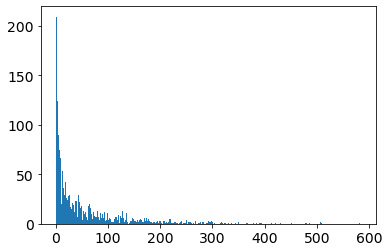

In [153]:
# Check number of reviews per movies
plt.hist((ratings != 0).sum(axis = 0), bins = 320)
plt.show()


We observe that a lot of movies have very few ratings. Since we want to provide a recommender system based on ratings we need to threshold the movies to make sure to have enough ratings. We want the movies to have a minimum of 5 ratings to be taken into consideration.


In [132]:
VALID_INDICES = ((ratings != 0).sum(axis = 0) >= 5) # Indices of movies with at least 5 ratings

In [154]:
'''Build the filtered ratings containing only movies with at least 5 ratings'''

filtered_ratings = ratings[:, VALID_INDICES]
filtered_ratings.shape

(943, 1349)

### 1.1 Distances metrics

To determine the distance between two nodes, whether they are movies or users, we choose to relate them with respect to their common ratings and how close to each other they are. The main issue we meet is the lack of common ground between movies or users. We need to decide whether we want to put more weight on how many movies two users have both seen, or how close their ratings. To do so, we compose the weights between two nodes in three parts:

* N = Proportion of movies that two users have both seen OR of users that have seen two given movies. Normalized using min-max.
* C = Cosine similarity between ratings of two users OR between ratings given to two movies
* E = Normalized euclidean distance between the ratings of movies that two users have both seen OR between the ratings common users have given a movie

In [134]:
'''Custom metric functions'''


def number_common(u, v) :
    '''
    Compute the proportion of common non-zeros values between two vectors
    ------------------------------------------------------
    Parameters:
    ----------
    u, v : two vectors
    ------------------------------------------------------
    Return
    ------------------------------------------------------
    proportion of common non-zeros values
    '''
    return ((u != 0) & (v != 0)).sum()

def euclidean_distance_common(u, v) :
    '''
    Compute the euclidean distance between common non-zeros values of two vectors
    ------------------------------------------------------
    Parameters:
    ----------
    u, v : two vectors
    ------------------------------------------------------
    Return
    ------------------------------------------------------
    euclidean distance between common non-zeros values
    '''
    # get common values
    mask = ((u != 0) & (v != 0))
    count = mask.sum()
    if (count == 0):
        return 5

    return np.sqrt(sqeuclidean(u[mask], v[mask]) / count)

In [135]:
'''Movie based distance matrices'''
# N
common_movies = squareform(pdist(filtered_ratings.T, metric = number_common))
common_movies -= np.diag(np.diag(common_movies))
common_movies = 1 - (common_movies - common_movies.min()) / (common_movies.max() - common_movies.min()) - np.eye(common_movies.shape[0])

# C
cosine_similarity_movies = squareform(pdist(filtered_ratings.T, metric = 'cosine'))

# E
euclidean_distance_matrix_movies = 0.2 * squareform(pdist(filtered_ratings.T, metric = euclidean_distance_common))

In [136]:
'''User based distance matrices'''
# N
common_users = squareform(pdist(filtered_ratings, metric = number_common))
common_users -= np.diag(np.diag(common_users))
common_users = 1 - (common_users - common_users.min()) / (common_users.max() - common_users.min()) - np.eye(common_users.shape[0])

# C
cosine_similarity_users = squareform(pdist(filtered_ratings, metric = 'cosine'))

# E
euclidean_distance_matrix_users = 0.2 * squareform(pdist(filtered_ratings, metric = euclidean_distance_common))

### 1.2 Distances distribution visualization

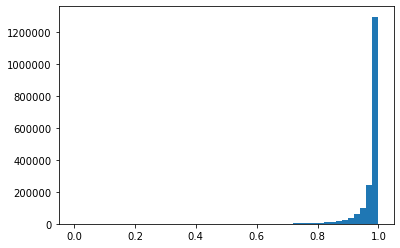

In [137]:
plt.hist(common_movies.flatten(), bins = 50)
plt.show()

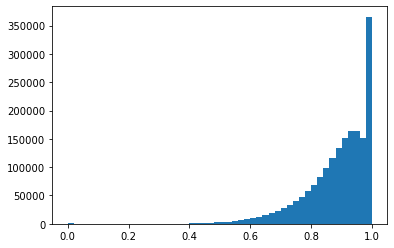

In [138]:
plt.hist(cosine_similarity_movies.flatten(), bins = 50)
plt.show()

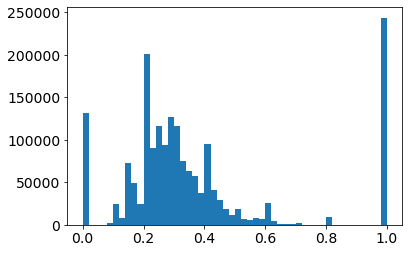

In [155]:
plt.hist(euclidean_distance_matrix_movies.flatten(), bins = 50)
plt.show()

We observe that the different distance metrics have varying distributions. We then visualize a combination of the three distances using arithmetic mean to see if it has satisfying properties.

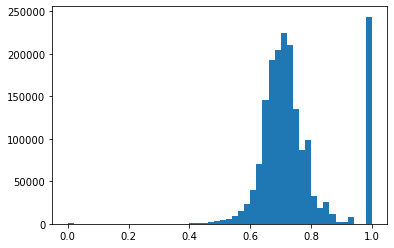

In [140]:
plt.hist((cosine_similarity_movies.flatten() + euclidean_distance_matrix_movies.flatten() + common_movies.flatten()) / 3, bins = 50)
plt.show()

We can see the distribution now follow sort of a gaussian distribution which has satisfying properties. However, we will then try to tune the coefficient of each metrics to reach optimal results.

### 1.3 Building Adjacency matrix

As mentioned above, we aim to tune the different coefficient to reach more satisfying properties and better results. One issue we often ran into is that we had too many edges between each nodes, which affected our recommendation model. Thus, the first thing we aim to do here is to tune the coefficients such that we obtain adjacency matrices that have a low average degree.

In [141]:
def build_adjacency(d1, d2, d3):
    '''
    Given three distances matrices, build 10 adjacency matrices with a unique connected component and with minimum average degree
    ------------------------------------------------------
    Parameters:
    ----------
    d1, d2, d3 : distance matrices
    ------------------------------------------------------
    Return
    ------------------------------------------------------
    adjacencies : 10 adjacency matrices with unique connected component and minimum average degree
    params : coefficients and threshold required to obtain the respective adjacency matrices
    avg_degrees : averages degrees of respective adjacency matrices
    '''

    # Ranges for coefficients and threshold
    c1 = np.logspace(-2, 2, 5)
    c2 = np.logspace(-2, 2, 5)
    c3 = np.logspace(-2, 2, 5)
    threshold = np.linspace(0.2, 0.8, 3)
    
    # Initiate output lists and
    params = []
    adjacencies = []
    avg_degrees = []
    
    # Iterate over all parameters
    for a in c1:
        for b in c2:
            for c in c3:
                for t in threshold:
                    
                    # Build adjacency matrix with corresponding parameters
                    adjacency = (a * d1 + b * d2 + c * d3) / (a + b + c)
                    adjacency = (1 - adjacency - np.eye(adjacency.shape[0])) * (adjacency < t)
                    
                    # Check for unique connected component
                    temp_G = nx.from_numpy_matrix(adjacency)
                    ncc = nx.number_connected_components(temp_G)

                    if (ncc == 1) :
                        avg_degree = adjacency.sum(axis = 0).mean()
                        
                        # Condition to have a maximum of 10 adjacency matrices
                        if (len(adjacencies) < 10):
                            
                            # Add values to output
                            adjacencies.append(adjacency)
                            avg_degrees.append(avg_degree)
                            params.append((a, b, c, t))
                        elif (avg_degree < np.max(avg_degrees)):
                            
                            # Replace values with highest average degree
                            index = np.argmax(avg_degrees)
                            adjacencies[index] = adjacency
                            avg_degrees[index] = avg_degree
                            params[index] = (a, b, c, t)
                    
    return adjacencies, params, avg_degrees


In [142]:
adjacencies, P, D = build_adjacency(cosine_similarity_movies, euclidean_distance_matrix_movies, common_movies)

In [429]:
temp = (1 * cosine_similarity_movies + 1 * euclidean_distance_matrix_movies + 0.1 * common_movies) / (2.1)
temp = (1 - temp - np.eye(temp.shape[0])) * (adjacency < 0.6)
temp_G = nx.from_numpy_matrix(adjacency)
ncc = nx.number_connected_components(temp_G)
print(ncc)
temp.sum(axis = 0).mean()

1


469.8415308735115

### 1.4 Exploration of the adjacency matrix
Here we aim to visualize the different properties of the adjacency matrix. Analysis is provided in the report

In [156]:
# Take adjacency matrix with lowest average degree
lowest = np.argmin(D)
A_movies = adjacencies[lowest] > 0

# Compute degree distribution
degrees_movies = A_movies.sum(axis = 0)

# Generate graph using NetworkX
G = nx.from_numpy_matrix(A_movies)

m = G.number_of_edges()
n = G.number_of_nodes()

# Generate ErDos Renyi Graph with same number of edges and nodes
p = 2*m/(n*(n-1))
G_er = nx.erdos_renyi_graph(n, p)

# Generate Barabasi Albert Graph with same number of edges and nodes
q = int(round((n-np.sqrt(n**2-4*m))/2))
G_ba = nx.barabasi_albert_graph(n, q)

# Generate Power Law network
p = nx.average_clustering(G)
G_pl = nx.powerlaw_cluster_graph(n, q, p)

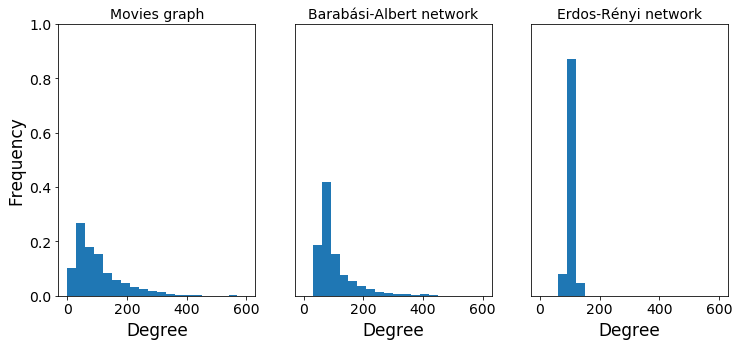

In [157]:
# Generate plots of different graphs for visualization and comparison
SMALL_SIZE = 17
MEDIUM_SIZE = 14  # do not change!
BIGGER_SIZE = 50

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=SMALL_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

plt.figure(figsize=(12, 5))
plt.subplot(131)
deg_hist_normalization = np.ones(degrees_movies.shape[0]) / degrees_movies.shape[0]
plt.title('Movies graph')
plt.hist(degrees_movies, weights=deg_hist_normalization, range=(0, 600), bins=20)
plt.xlabel("Degree")
plt.ylabel("Frequency")
plt.ylim(0, 1.0)

plt.subplot(132)
plt.title('Barabási-Albert network')
ba_degrees = dict(G_ba.degree()).values()
plt.xlabel("Degree")
plt.hist(ba_degrees, weights=deg_hist_normalization, range=(0, 600), bins=20)
plt.ylim(0, 1.0)
plt.yticks([], [])

plt.subplot(133)
plt.title('Erdos-Rényi network')
er_degrees = dict(G_er.degree()).values()
plt.xlabel("Degree")
plt.hist(er_degrees, weights=deg_hist_normalization, range=(0, 600), bins=20)
plt.ylim(0, 1.0)
plt.yticks([], [])
plt.show()

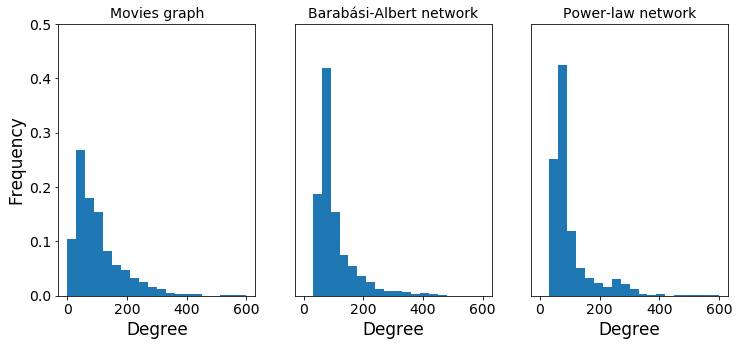

In [158]:
# Plot the degree distribution of the movies graph
plt.figure(figsize=(12, 5))
plt.subplot(131)
deg_hist_normalization = np.ones(degrees_movies.shape[0]) / degrees_movies.shape[0]
plt.title('Movies graph')
plt.hist(degrees_movies, weights=deg_hist_normalization, range=(0, 600), bins=20)
plt.xlabel("Degree")
plt.ylabel("Frequency")
plt.ylim(0, 0.5)

# Plot the degree distribution of a Barabási-Albert network
plt.subplot(132)
plt.title('Barabási-Albert network')
ba_degrees = dict(G_ba.degree()).values()
plt.xlabel("Degree")
plt.hist(ba_degrees, weights=deg_hist_normalization, range=(0, 600), bins=20)
plt.ylim(0, 0.5)
plt.yticks([], [])

# Plot the degree distribution of a Power-law network
plt.subplot(133)
plt.title('Power-law network')
pl_degrees = dict(G_pl.degree()).values()
plt.xlabel("Degree")
plt.hist(pl_degrees, weights=deg_hist_normalization, range=(0, 600), bins=20)
plt.ylim(0, 0.5)
plt.yticks([], [])
plt.savefig('degree_distributions.pdf')
plt.show()

### 1.5 Analysis of node properties

In [159]:
# Print the average clustering coefficients of the different graphs
print("Movies graph average clustering:", nx.average_clustering(G))
print("ER graph average clustering:", nx.average_clustering(G_er))
print("BA graph average clustering:", nx.average_clustering(G_ba))
print("PL graph average clustering:", nx.average_clustering(G_pl))

# Print the diameter of the different graphs
print("Movies graph diameter", nx.algorithms.distance_measures.diameter(G))
print("ER graph diameter", nx.algorithms.distance_measures.diameter(G_er))
print("BA graph diameter", nx.algorithms.distance_measures.diameter(G_ba))
print("PL graph diameter", nx.algorithms.distance_measures.diameter(G_pl))

Movies graph average clustering: 0.29531840478924454
ER graph average clustering: 0.07616623180552054
BA graph average clustering: 0.14818939388282934
PL graph average clustering: 0.18902463963244515
Movies graph diameter 3
ER graph diameter 3
BA graph diameter 3
PL graph diameter 3


## 2. Heat diffusion using PyGSP

### 2.1 Parameter tuning
When building the adjacency matrix we have to deal with several parameters that affect the efficiency of our model. The coefficients of the different distance metrics are one example, and we tuned them to not have to many edges previously. However, our main goal is to reach the best accuracy, and thus we compute the RMSE and tune the parameters in order to reach the lower RMSE.
* Coefficients: We previously computed 10 different adjacency matrices with different coefficients that each have an acceptable numebr of edges. We now want to choose between those 10 adjacency matrices for the one that offers the lowest RMSE
* Number of iterations: Our model is built by iterating the heat filter a certain number of times. It is possible to iterate too many times and we thus want to reach the right number of iterations by once again searching for the number offering the lowest RMSE

In [160]:
def rescale(a, b, signal):
    '''
    Helper method which scales movie ratings to a given range between a and b
    ------------------------------------------------------
    Parameters:
    ----------
    a : minimum value after scaling
    b : maximum value after scaling
    signal : the signal to rescale
    ------------------------------------------------------
    Return: the scaled signal
    '''
    return a + ((signal - np.min(signal))*(b-a))/(np.max(signal) - np.min(signal))

In [161]:
def diffuse(signal, s, g, iterations = 1, plot = False):
    '''
    Method that realizes signal diffusion by small iteration steps. 
    ------------------------------------------------------
    Parameters:
    ----------
    signal : the original rating signal of the user
    s : signal on which diffusion will be applied
    g : graph on which heat filters are applied
    iterations : number of iterations
    plot : plots the graph of the diffused signal
    ------------------------------------------------------
    Return:
    ------------------------------------------------------
    s : the diffused signal
    '''
    # diffuse signal N times
    for i in range(iterations):
        # apply the chebyshev polynomials to the graph g to which a filter is applied
        s = g.filter(s, method = 'chebyshev')
        # rescale the signal
        s = rescale(np.min(s),5, s)
        # retrieve known ratings
        indices = (signal != 0)
        s[indices] = signal[indices]
        # plot the signal
        if plot:
            G.plot_signal(s, vertex_size = 10)
    
    return s
    

In [162]:
def compute_rmse(user_ratings, graph, iterations, remove_split = 0.4):
    '''
    Compute the RMSE for a prediction on all users. 
    The method first removes a part of already rated movies in order to compute a prediction on those ones.
    Then it computes the RMSE, where the original signals removed values are the test outputs and the prediction is the training output.    
    ------------------------------------------------------
    Parameters:
    ----------
    user_ratings : the original rating matrix for all users
    graph : graph on which heat filters are applied
    iterations : number of iterations
    remove_split : percentage of the data to be removed for the test
    ------------------------------------------------------
    Return:
    ------------------------------------------------------
    RMSEs : list containing the RMSE of each iteration
    '''
    n_users, n_movies = user_ratings.shape
    n_movies_to_remove = int(remove_split*n_movies)
    cols_to_remove = np.arange(n_movies)
    
    np.random.seed(1)
    # Get the indices of the desired ratio of the data to remove randomly (we remove entire columns)
    np.random.shuffle(cols_to_remove)
    cols_to_remove = cols_to_remove[:n_movies_to_remove]
    
    predictions = np.zeros((n_users, n_movies))
    new_ratings = user_ratings.copy()
    
    # Remove ratings from the desired columns 
    new_ratings[:, cols_to_remove] = 0
    temp = new_ratings.copy()
    
    # List where RMSE's are stored
    RMSEs = []
    
    for i in range(iterations):
        # make predictions on the train data for all users
        for user in range(n_users):
            predictions[user, :] = diffuse(new_ratings[user, :], temp[user, :], graph)
            temp[user, :] = predictions[user, :]
            
        # remove all unrated movies by the user, we compute the RMSE only between predictions of already rated movies
        predictions[user_ratings == 0] = 0
        
        # Compute RMSE
        MSE = (user_ratings[:, cols_to_remove] - predictions[:, cols_to_remove])**2
        RMSE = np.sqrt(1/2 * np.sum(MSE)/(user_ratings[:, cols_to_remove] != 0).sum())
        
        RMSEs.append(RMSE)
    
    return RMSEs

In [163]:
'''Compute rmse for all adjacencies obtained previously'''
# Initialize rmse list
errors = []

# Iterate over adjacency matrices
for adjacency in adjacencies:
    
    # Construct PyGSP Graph and initialize Laplacian and Fourier Basis
    G = graphs.Graph(adjacency)
    G.compute_laplacian(lap_type='combinatorial')
    G.compute_fourier_basis()

    # Set Tau relatively small for local diffusion
    tau = 5
    
    # Apply heat filter bank on the graph
    g = filters.Heat(G, tau)
    min_error = np.min(compute_rmse(filtered_ratings, g, 1))
    errors.append(min_error)
print(errors)

# Get index of adjacency matrix with lowest rmse
LOWEST_ERROR_INDEX = np.argmin(errors)

[2.2487045313660556, 2.4543854190386742, 2.4544472727876534, 2.4544472727876534, 2.251743579320429, 2.2487045313660556, 2.2520622163522606, 2.2517435793204283, 2.2487045313660556, 2.1909463904967126]


In [164]:
# Get adjacency matrix with lowest rmse
adjacency = adjacencies[LOWEST_ERROR_INDEX]

G = graphs.Graph(adjacency)
G.compute_laplacian(lap_type='combinatorial')
G.compute_fourier_basis()

tau = 5
g = filters.Heat(G, tau)
RMSEs = compute_rmse(filtered_ratings, g, 20)
print(RMSEs)

# Get number of iterations with lowest RMSE
OPTIMAL_NB_ITERATIONS = np.argmin(RMSEs) + 1

[2.1909463904967126, 1.8413642506872447, 1.5643585370670674, 1.3661586628913014, 1.2290376254493465, 1.1377606712871602, 1.076241110371452, 1.036322783459112, 1.0119744184553336, 0.999782505817925, 0.9943240121773688, 0.9926125613958657, 0.9931785186318218, 0.9952023632234938, 0.9971187727835071, 0.9993989473368572, 1.001506649770603, 1.0028054066858272, 1.0033414974175208, 1.0028568345584916]


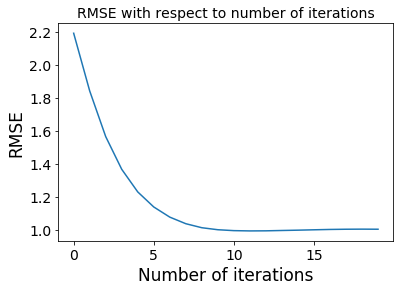

In [165]:
plt.plot(RMSEs)
plt.title("RMSE with respect to number of iterations")
plt.xlabel("Number of iterations")
plt.ylabel("RMSE")
plt.show()

In [428]:
'Now that we have the best adjacency, we export the resulting graph to Gephi for visualization'
Graph = nx.from_numpy_array(adjacency)
nx.write_gexf(Graph, 'Data/adjacency_movies.gexf')

### 2.2 Applying signal diffusion on the graph

#### 2.2.1 Visualization
Now that we have our optimal adjacency matrix as well as our diffusion model, we can apply the model to our graph and signal and observe the results.

In [205]:
# Set coordinates of the graph
G.set_coordinates()

In [410]:
# Choose a user to use his ratings as signal
USER_INDEX = 86

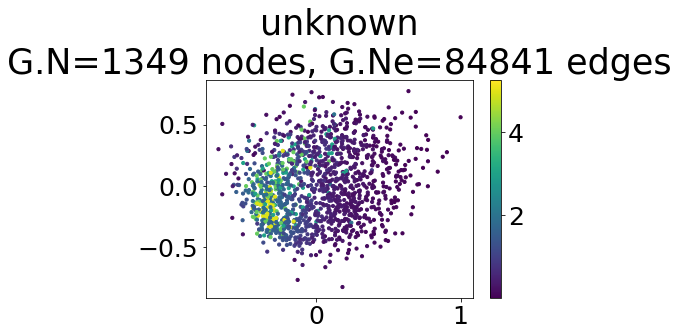

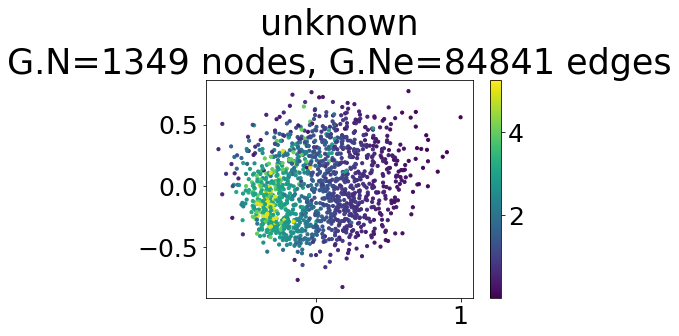

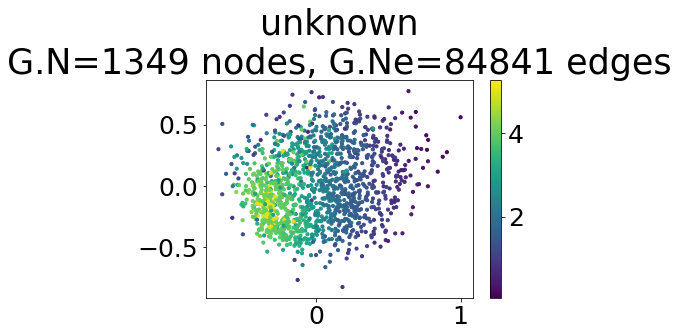

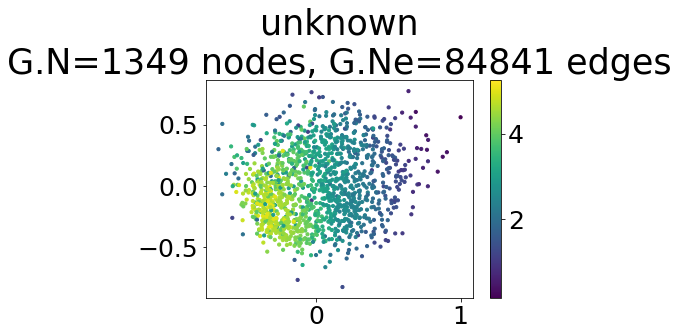

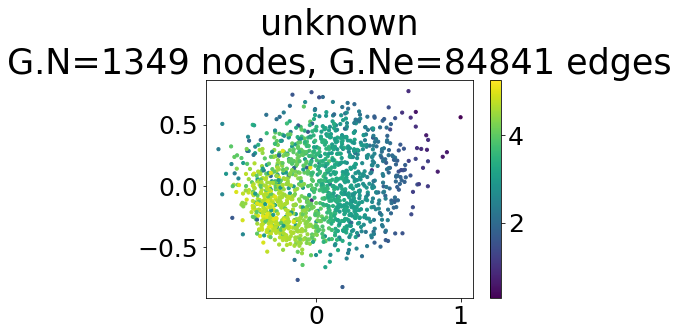

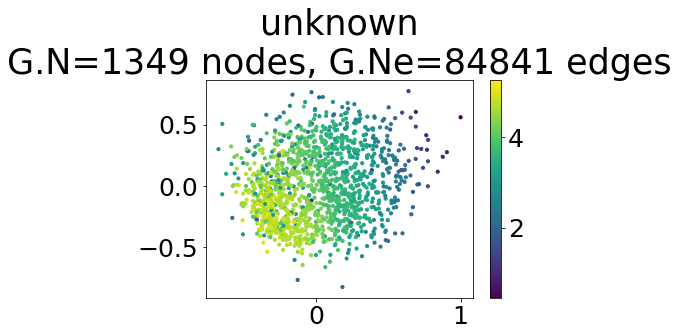

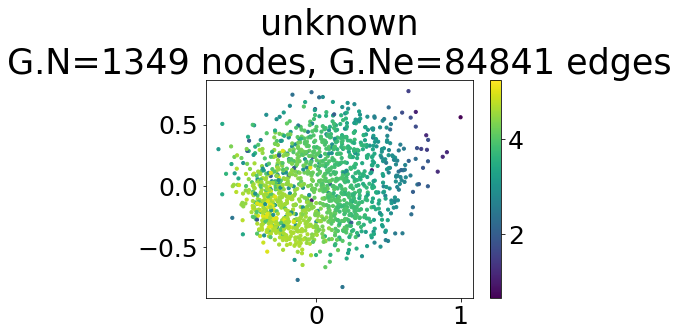

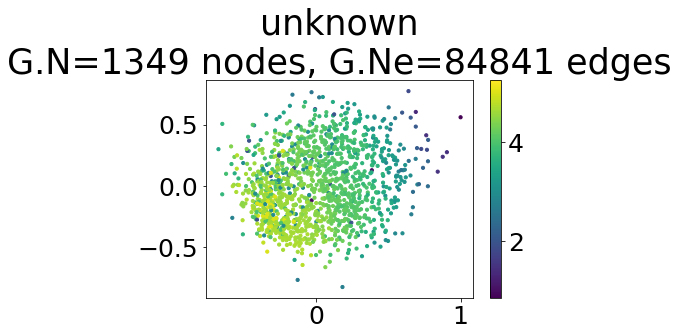

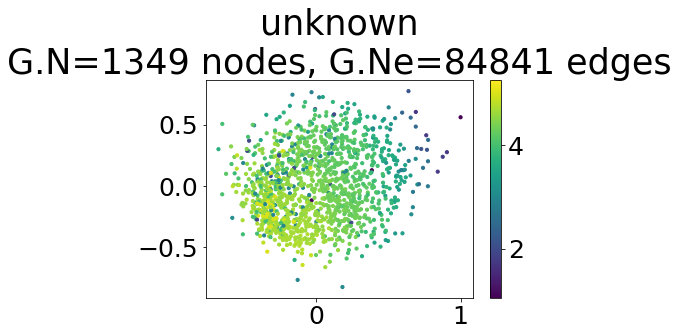

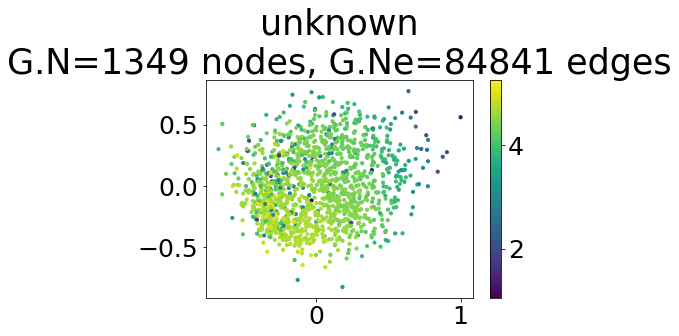

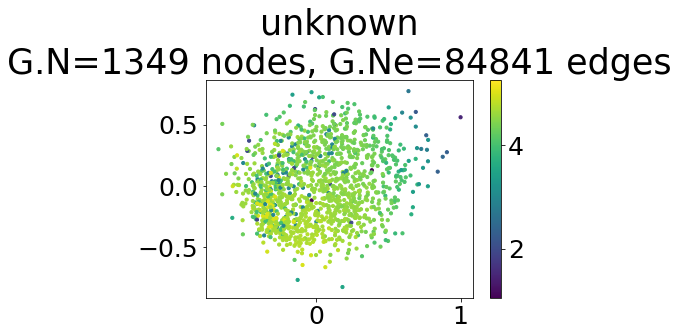

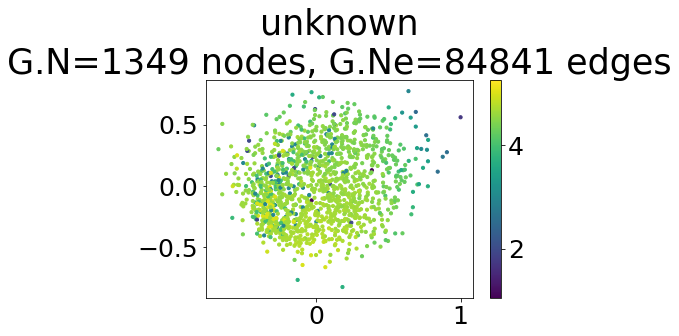

In [416]:
# Test signal diffusion for given user ratings
signal = filtered_ratings[USER_INDEX]
s = diffuse(signal, signal.copy(), g, iterations = OPTIMAL_NB_ITERATIONS, plot = True)

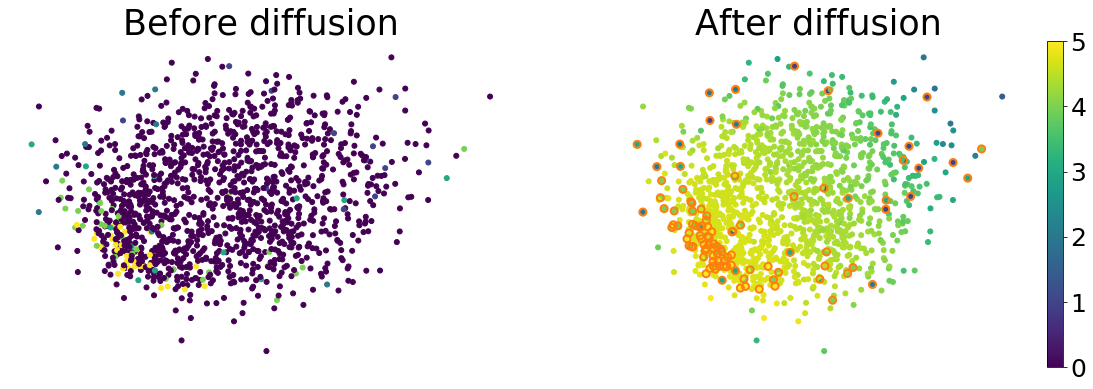

In [343]:
# the signal of the user
signal = filtered_ratings[USER_INDEX]
# diffusion of the signal
s = diffuse(signal, signal.copy(), graph, iterations = OPTIMAL_NB_ITERATIONS)

SMALL_SIZE = 25
MEDIUM_SIZE = 35
BIGGER_SIZE = 50

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=SMALL_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

# plot the initial signal
fig, axes = plt.subplots(1, 2, figsize=(20, 6))
G.plot_signal(signal, 
              vertex_size=25, 
              limits=[0, 5], 
              ax=axes[0], 
              colorbar=False)
axes[0].set_title("Before diffusion")
axes[0].axis('off')

# plot signal after diffusion
G.plot_signal(s, 
              vertex_size=25, 
              limits=[0, 5], 
              ax=axes[1], 
              colorbar=True, 
              highlight=(signal != 0))
axes[1].set_title("After diffusion")
axes[1].axis('off')
plt.savefig("test.pdf")

## 3 Results and comparisons

In [195]:
def get_recommendations(signal, s, n_recommendations, n_user):
    
    '''
    Helper method that retrieves the best n_recommendations for a given user
    ------------------------------------------------------
    Parameters:
    ----------
    signal : signal after diffusion
    s : the original movie ratings signal
    n_recommendations : number of recommendations to retrieve
    n_user : the index of the user to which we make the recommendations
    ------------------------------------------------------
    Return:
    ------------------------------------------------------
    sorted_indices : indices of the recommended movies
    sorted_values  : rating values of the movies to recommend
    '''
    # Put the ratings of movies the user has already seen to -1 to avoid recommending them
    rated_indices = (signal != 0)
    s[rated_indices] = -1
    # Retrieve the indices and the values of the best rated movies after diffusion
    ratings_user = ratings[n_user].copy()
    ratings_user[VALID_INDICES] = s
    sorted_indices = np.argsort(-ratings_user)
    sorted_values = ratings_user[sorted_indices]
    
    return sorted_indices[:n_recommendations], sorted_values[:n_recommendations]

In [196]:
def print_recommendations(recommendation_indices):
    '''
    Helper method that prints the movie names for recommendations
    ------------------------------------------------------
    Parameters:
    ----------
    recomendation_indices : indices of the movies to be recommended
    ------------------------------------------------------
    Output: titles printed to the console
    '''
    movie_names = movies.movie_title[recommendation_indices]
    print(movie_names)

In [417]:
# Get recommendations for a given user using our model
recommendation_indices, recommendation_values = get_recommendations(signal, s, 5, USER_INDEX)
print(recommendation_values[:10])
print_recommendations(recommendation_indices)

[5.         5.         4.98165316 4.97122001 4.95865196]
1188                        Prefontaine (1997)
1557                          Aparajito (1956)
1511    World of Apu, The (Apur Sansar) (1959)
923                        White Squall (1996)
1125           Old Man and the Sea, The (1958)
Name: movie_title, dtype: object


In [227]:
filtered_data_indices = data['item_id'].map(lambda x: indices[x])
filtered_data = data[filtered_data_indices]

In [212]:
def evaluate_model(model, filtered_data, user_ratings, remove_split=0.4):
    '''
    Computes the rmse of a model from the surprise library (CoCluster or SVD Matrix factorization) 
    ------------------------------------------------------
    Parameters:
    ----------
    model : model from the surprise library
    filtered_data : filtered from the data dataframe
    user_ratings : filtered ratings
    remove_split : proportion of data taken for testing and computing rmse
    ------------------------------------------------------
    Output: 
    -------
    RMSE
    model given in argument
    '''
    
    n_users, n_movies = user_ratings.shape
    n_movies_to_remove = int(remove_split*n_movies)
    cols_to_remove = np.arange(n_movies)
    np.random.seed(1)
    np.random.shuffle(cols_to_remove)
    cols_to_remove = cols_to_remove[:n_movies_to_remove]

    # create test and train dataset
    test_indexes = filtered_data['item_id'].map(lambda movie_id: movie_id in cols_to_remove)
    train_indexes = ~test_indexes
    train_dataset = Dataset.load_from_df(filtered_data[train_indexes].drop("ts", axis=1), 
                                         Reader())
    train_dataset = train_dataset.build_full_trainset()
    
    # fit the model
    model.fit(train_dataset)

    # compute the RMSE on the test dataset
    mse = 0
    for i, row in filtered_data[test_indexes].iterrows():
        ground_truth = row['rating']
        estimated = model.predict(row['user_id'], row['item_id']).est
        mse += (ground_truth - estimated) ** 2
    rmse = np.sqrt(1 / 2 * mse / sum(test_indexes))
    return rmse, model

In [213]:
rmse_cocl, cocl = evaluate_model(CoClustering(), filtered_data, filtered_ratings)
print(rmse_cocl)

0.7908705646905959


In [214]:
rmse_svd, svd = evaluate_model(SVD(), filtered_data, filtered_ratings)
print(rmse_svd)

0.7564376928469153


In [425]:
def baseline_recommendations(model, user):    
    '''
    Get predictions for a given user using a given model from the surprise library
    -----------------------------------------------------
    Parameters:
    ----------
    model : model from the surprise library
    user : id of the user
    ------------------------------------------------------
    Output:
    ------
    predictions
    '''
    result = np.zeros(n_movies)
    for i, movie_id in enumerate(range(n_movies)):
        result[i] = model.predict(user, movie_id).est
    return result

In [216]:
def print_recommendations(recommendation_indices):
    '''
    Print the title of the movies from given indices
    -----------------------------------------------------
    Parameters:
    ----------
    recommendation_indices : indices of movies recommended
    ------------------------------------------------------
    Output:
    ------
    prints the title of the movies
    '''
    movie_names = movies.movie_title[recommendation_indices]
    print(movie_names)

In [426]:
# Get signal and compute prediction using SVD Matrix factorization
signal = filtered_ratings[USER_INDEX]
s = baseline_recommendations(svd, USER_INDEX)
get_recommendations(signal, s, 10, USER_INDEX)

(array([1188,  174,  318,  169,  172,  204,  699,  186,  524,  521],
       dtype=int64),
 array([5.        , 4.90247276, 4.83384131, 4.78890741, 4.75378828,
        4.69045861, 4.6871878 , 4.64154796, 4.61707678, 4.59911186]))

In [427]:
# Get the recommendation
recommendation_indices, recommendation_values = get_recommendations(signal, s, 5, USER_INDEX)
print(recommendation_values[:10])
print_recommendations(recommendation_indices)

[5.         4.90247276 4.83384131 4.78890741 4.75378828]
1188                 Prefontaine (1997)
174                       Brazil (1985)
318     Everyone Says I Love You (1996)
169              Cinema Paradiso (1988)
172          Princess Bride, The (1987)
Name: movie_title, dtype: object
